<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>
<br />
Алексей, доброго дня! рад приветствовать тебя в финале) <br />
Вот и он подобрался, поздравляю. Остался последний рывок в этом марафоне)<br>
<br />
Меня зовут Николай. <br />И на этом этапе Вашего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='purple'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако что есть ещё что-то или в коде или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />
<font color='green'>Как и всегда в спринтах - ставлю своей целью максимально помочь. Поэтому, все мои комментарии - это только способ передать свой опыт для помощи в твоих достижениях.

# Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

# Содержание 
* [Изучение файлов](#analyse_files)
* [Вопросы](#questions)
* [План](#plan)
* [Первичная подготовка данных](#prepare_data)
* [Исследовательский анализ данных](#exploratory_data_analysis)
* [Подготовка данных для моделей](#prepare_data_for_models)
* [Обучение моделей](#models_train)
* [Вывод](#conclusion)

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from collections import namedtuple

RANDOM_STATE = 12345

pd.set_option('display.max_columns', None)

numeric_columns = ['MonthlyCharges', 'TotalCharges', 'TotalDays']
categorial_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines',
]

In [2]:
def analyze_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    display(df.describe())
    df.info()

def plot_numerical(df):
    cols = 3
    rows = 2

    plt.figure(figsize=(15, 10))

    idx = 0
    for column in numeric_columns:
        idx += 1 
    
        plt.subplot(rows, cols, idx)
        plt.hist(df[column])
        plt.title(column)
    
    for column in numeric_columns:
        idx += 1 
    
        plt.subplot(rows, cols, idx)
        plt.boxplot(df[column])
        plt.title(column)
        
    plt.show()

    display(df[numeric_columns].describe())
    
def upsample(features, target, repeat):     
    features_zeros = features[target == 0]     
    features_ones = features[target == 1]     
    target_zeros = target[target == 0]     
    target_ones = target[target == 1] 

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)     
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)     
    
    features_upsampled, target_upsampled = shuffle(         
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)          
    
    return features_upsampled, target_upsampled

def plot_roc_curve(target_test, predictions):
    print('ROC-AUC score', roc_auc_score(target_test, predictions))
    
    fpr, tpr, thresholds = roc_curve(target_test, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>с подготовкой - понятно.

<a name="analyse_files"></a>
## Изучение файлов

In [3]:
contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

In [4]:
analyze_df(contract_df)

Количество стобцов: 8
Количество строк: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract_df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [6]:
contract_df['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

**Выводы**:
* В данных нет пропусков
* Надо переименовать `customerID` -> `CustomerID`
* `BeginDate` и `EndDate` надо перевести в формат даты 
* `No` в `EndDate` означает, что пользователь продолжает пользоваться услугами - это целевой признак 
* После выделения целевого признака надо будет заменить `No` на `01.02.2020` в `EndDate`
* `TotalCharges` надо перевести в числовой тип
* К `PaymentMethod`, `Type` и `PaperlessBilling` надо применить One Hot Encoding

In [7]:
analyze_df(personal_df)

Количество стобцов: 5
Количество строк: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Выводы**:
* В данных нет пропусков
* Надо переименовать `customerID` -> `CustomerID`, `gender` -> `Gender`
* К `gender`, `Partner` и `Dependents` надо применить One Hot Encoding

In [8]:
analyze_df(internet_df)

Количество стобцов: 8
Количество строк: 5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2135-DQWAQ,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
internet_df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

**Выводы**:
* В данных нет пропусков
* Данные есть не по всем клиентам
* Надо переименовать `customerID` -> `CustomerID`
* К `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` надо применить One Hot Encoding

In [10]:
analyze_df(phone_df)

Количество стобцов: 2
Количество строк: 6361


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,1763-WQFUK,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


**Выводы**:
* В данных нет пропусков
* Данные есть не по всем клиентам
* Надо переименовать `customerID` -> `CustomerID`
* К `MultipleLines` надо применить One Hot Encoding

<a name="questions"></a>
## Вопросы

* Целевой признак - если `EndDate` равен `No`? 
* Какую метрику надо использовать? 
* На какие значения метрики надо ориентироваться? 
* Можно ли ко всем категориальным значениям применить One Hot Encoding, поскольку категорий мало? 

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ОК, данные на базе) Судя по комментариям - тебе удалось глянуть их внимательно!

<a name="plan"></a>
## План

* Изучить данные в файлах - проверить типы, есть ли пропуски, надо ли преобразовывать данные 
* Подготовить данных на основе выводов, полученных на предыдущем шаге 
* Провести исследовательский анализ данных - вузализация данных, избавление от выбросов 
* Перебор моделей и подбор их параметров 
* Вывод по итогам работы

<a name="prepare_data"></a>
## Первичная подготовка данных

Переименуем столбцы, для того, чтобы они все были в одном формате 

In [11]:
contract_df = contract_df.rename(columns={'customerID': 'CustomerID'})
print(contract_df.columns.values)

['CustomerID' 'BeginDate' 'EndDate' 'Type' 'PaperlessBilling'
 'PaymentMethod' 'MonthlyCharges' 'TotalCharges']


In [12]:
personal_df = personal_df.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
print(personal_df.columns.values)

['CustomerID' 'Gender' 'SeniorCitizen' 'Partner' 'Dependents']


In [13]:
internet_df = internet_df.rename(columns={'customerID': 'CustomerID'})
print(internet_df.columns.values)

['CustomerID' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies']


In [14]:
phone_df = phone_df.rename(columns={'customerID': 'CustomerID'})
print(phone_df.columns.values)

['CustomerID' 'MultipleLines']


Добавим целевой признак `Churn`, который будет означать отказался клиент от услуг или нет.   
Если значение в столбце `EndDate` равно "No", то значит клиент не ушел и целевой признак равен 0.  
Если дата ухода есть, то целевой признак равен 1.

In [15]:
contract_df['Churn'] = (contract_df['EndDate'] != 'No').astype(int)
contract_df.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>Ок, с целевой - понятно.

Заменим все значения "No" в `EndDate` на дату выгрузки датасета (01.02.2020) 

In [16]:
contract_df['EndDate'] = contract_df['EndDate'].replace(['No'], ['2020-02-01'])
print(contract_df[contract_df['EndDate'] == 'No'].shape[0])

0


Переведем `EndDate` и `BeginDate` в формат даты 

In [17]:
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format='%Y-%m-%d')
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], format='%Y-%m-%d')
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
CustomerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


Заведем новый столбец `TotalDays`, который будет означать, сколько пользователь пользовался услугами 

In [18]:
contract_df['TotalDays'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.days

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>интересная идея!

Переведем `TotalCharges` в числовой тип 

In [19]:
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors ='coerce')
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
CustomerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null int64
TotalDays           7043 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


Видно, что в столбце `TotalCharges` появились пропуски, посмотрим на строки с ними 

In [20]:
contract_df[contract_df['TotalCharges'].isnull()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalDays
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Видно, что все эти клиенты подключены всего 1 день, заполним пропуски в `TotalCharges` на 0

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>да, верно, это новички. Хорошо раскрутил)

In [21]:
contract_df['TotalCharges'] = contract_df['TotalCharges'].fillna(0)
contract_df['TotalCharges'].isnull().sum()

0

Объединим все данные в один датафрейм 

In [22]:
churn_df = contract_df \
    .merge(personal_df, how='left', on='CustomerID') \
    .merge(internet_df, how='left', on='CustomerID') \
    .merge(phone_df, how='left', on='CustomerID') 

Проверим, что все значения `CustomerID` уникальные 

In [23]:
churn_df['CustomerID'].is_unique

True

Установим `CustomerID` в качестве индекса

In [24]:
churn_df = churn_df.set_index('CustomerID')

In [25]:
analyze_df(churn_df)

Количество стобцов: 21
Количество строк: 7043


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalDays,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


,MonthlyCharges,TotalCharges,Churn,TotalDays,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.265370,985.996166,0.162147
std,30.090047,2266.794470,0.441561,747.587844,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,0.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null int64
TotalDays           7043 non-null int64
Gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes:

Пропуски в `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` и `MultipleLines` скорее всего означают, что услуги не подключены. 
Заменим пропуски на "No"

In [26]:
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    churn_df[column] = churn_df[column].fillna('No')

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>согласен.

In [27]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null int64
TotalDays           7043 non-null int64
Gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
MultipleLines       7043 non-null object
dtypes:

От пропусков избавились, теперь можно проанализировать данные

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>Хороший блок получился.

<a name="exploratory_data_analysis"></a>
## Исследовательский анализ данных

Посмотрим распределение значений для категориальных данных 

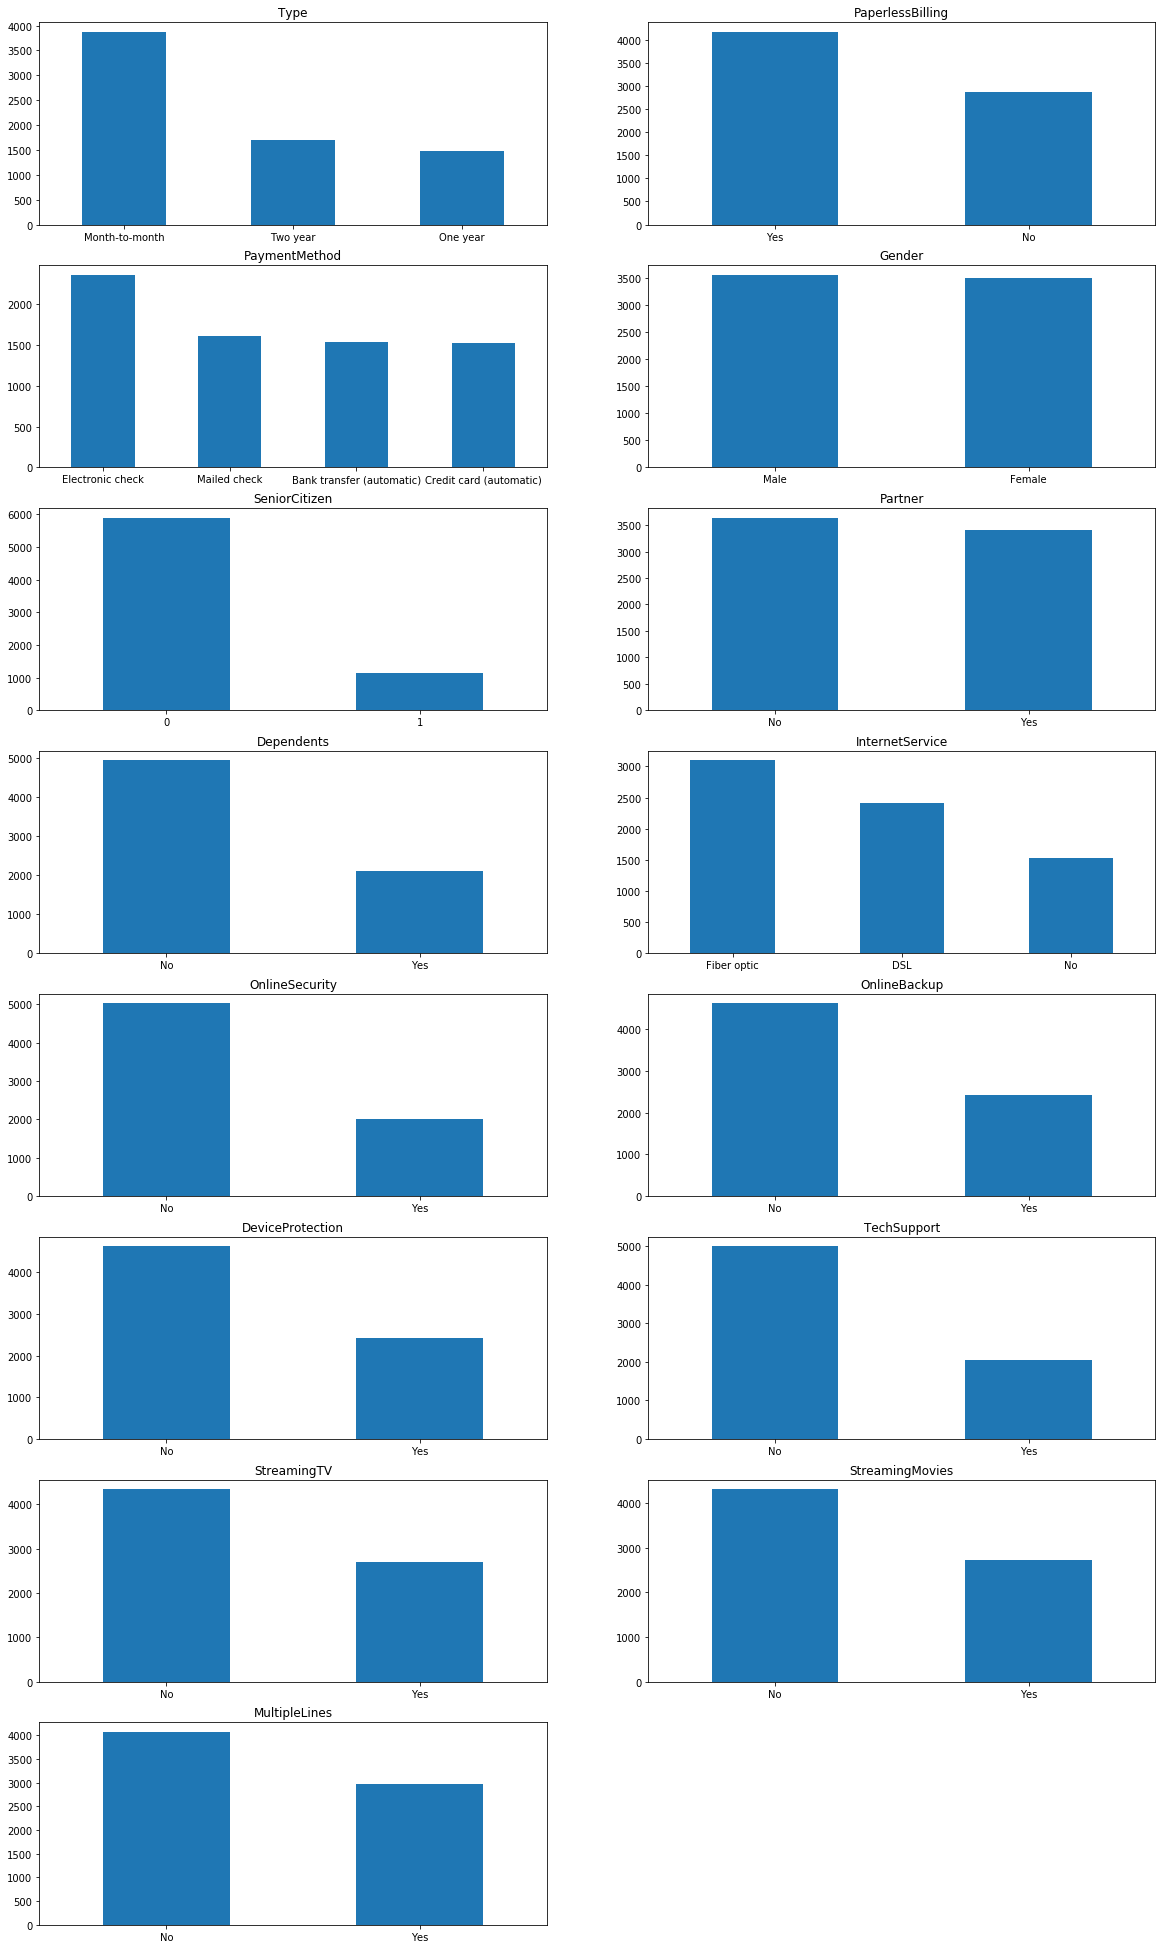

In [28]:
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, 35))

for idx, column in enumerate(categorial_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    churn_df[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0,
    )
        
plt.show()

**Выводы**:
* Самый популярный способ оплаты - помесячный 
* Люди чаще предпочитают получать счета в электронном виде и оплачивать их при помощи электронного чека
* Самый частый способ подключения - оптоволокно
* Дополнительные услуги `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` не пользуются популярностью у пользователей

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>Познавательно. ОК.

Посмотрим распределение значений и диаграммы размаха для количественных данных 

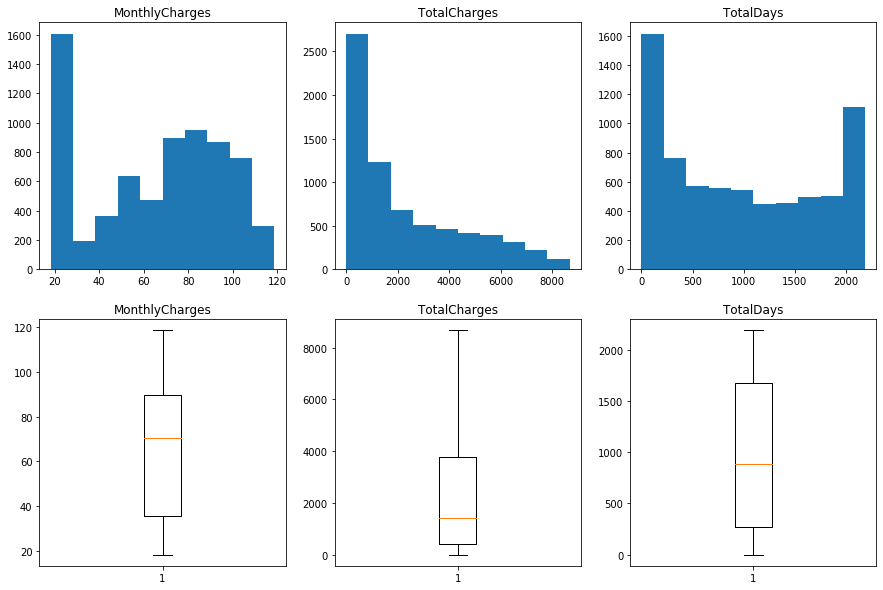

,MonthlyCharges,TotalCharges,TotalDays
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,985.996166
std,30.090047,2266.794470,747.587844
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,273.000000
50%,70.350000,1394.550000,883.000000
75%,89.850000,3786.600000,1676.000000
max,118.750000,8684.800000,2191.000000


In [29]:
plot_numerical(churn_df)

**Выводы**:
* Значения в столбце `TotalCharges` убывают, в то же время в столбце `MonthlyCharges` виден пик в райне 85 - это значит, что пользователи, которые платят за тариф много на долго не остаются 
* Также у `MonthlyCharges` виден пик в районе 20, что является минимальным значением
* В столбце `TotalDays` видно 2 пика - в районе новых клиентов и лояльных, которые долго пользуются услугами 
* Аномальных выбросов не видно

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ещё, гистограмма показывает бимодальность MonthlyCharges - несколько горбов) Это говорит о том, что в самой выборке есть несколько однородных выборок. Здесь, может быть, это завязано на количество услуг, или "болатый/бедный" клиент. В общем - можно попробовать выделить ещё фактор, который как раз объясняет эту бимодальность.

Посмотрим на распределение категорильных признаков относительно целевого признака `Result`

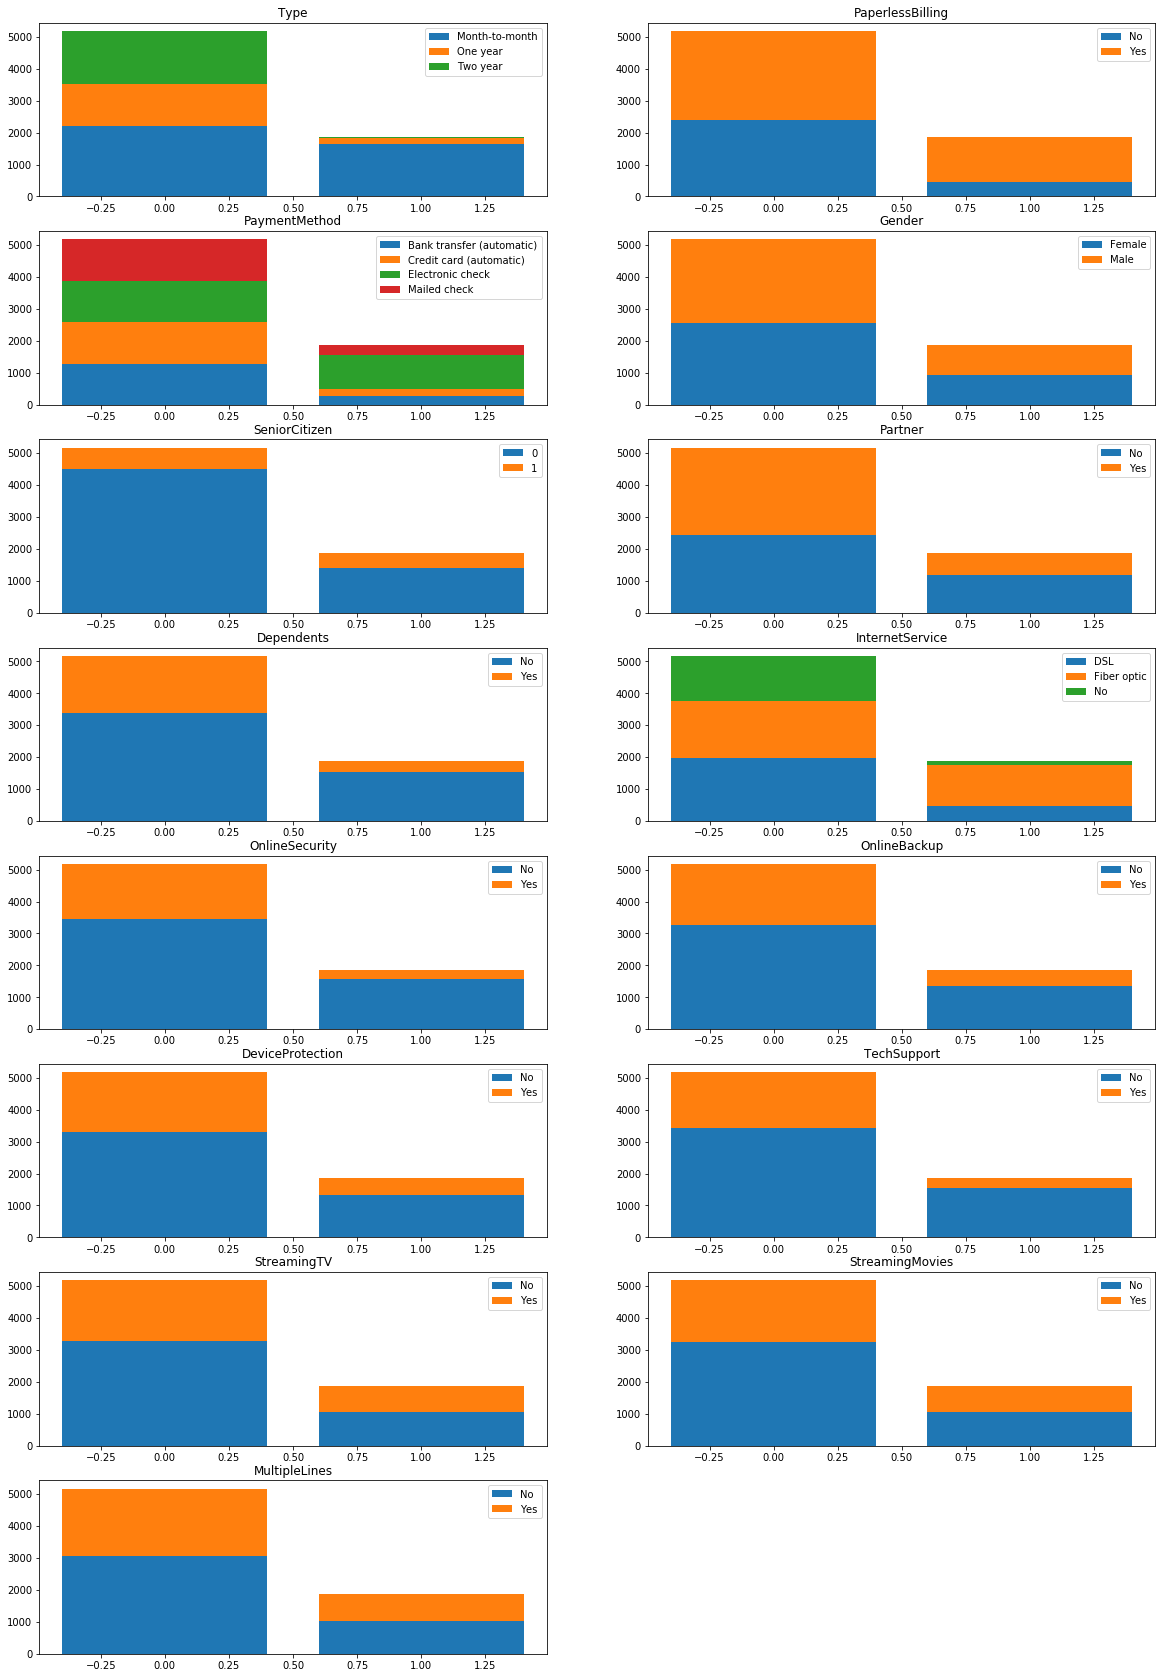

In [30]:
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, 30))

for idx, column in enumerate(categorial_columns):
    churn_grouped_df = churn_df.groupby([column, 'Churn'])['Churn'].count()
    churn_grouped_df = churn_grouped_df.unstack()
    
    ax = plt.subplot(rows, cols, idx + 1)

    ax.bar(churn_grouped_df.T.index, churn_grouped_df.T[churn_grouped_df.T.columns[0]], label=churn_grouped_df.T.columns[0])
    bottom = np.array(churn_grouped_df.T[churn_grouped_df.T.columns[0]])
    for color_idx, value in enumerate(churn_grouped_df.T.columns[1:]): 
        ax.bar(churn_grouped_df.T.index, churn_grouped_df.T[value], bottom=bottom, label=value)
        bottom += np.array(churn_grouped_df.T[value])
    plt.title(column)
    plt.legend()
        
plt.show()

**Выводы**:
* Доля отказов среди тех, кто использует помесячную оплату выше, чем среди тех, кто сразу платит за 1/2 года 
* Дополнительные услуги слабо влияют на отказы
* Пользователи использующие "Electronic check" для оплаты чаще отказываются от услуг, возможно в оплате онлайн есть какие-то неудобства
* Пенсионеры уходят чаще, но скорее всего не из-за качества услуг 
* Если пользователь не пользуется интернетом, то вероятность отказа ниже. Скорее всего это связано с тем, что более возрастные люди не хотят разбираться в том, как сменить поставщика услуг

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>классно

Посмотрим на распределение количественных признаков относительно целевого признака `Result`

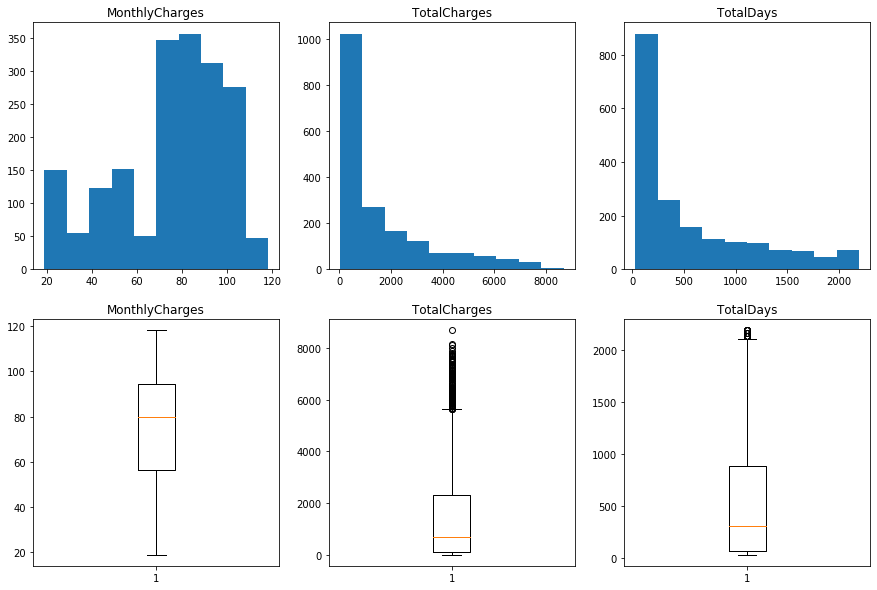

,MonthlyCharges,TotalCharges,TotalDays
count,1869.000000,1869.000000,1869.000000
mean,74.441332,1531.796094,547.352060
std,24.666053,1890.822994,594.389607
min,18.850000,18.850000,30.000000
25%,56.150000,134.500000,61.000000
50%,79.650000,703.550000,304.000000
75%,94.200000,2331.300000,883.000000
max,118.350000,8684.800000,2191.000000


In [31]:
plot_numerical(churn_df[churn_df['Churn'] == 1])

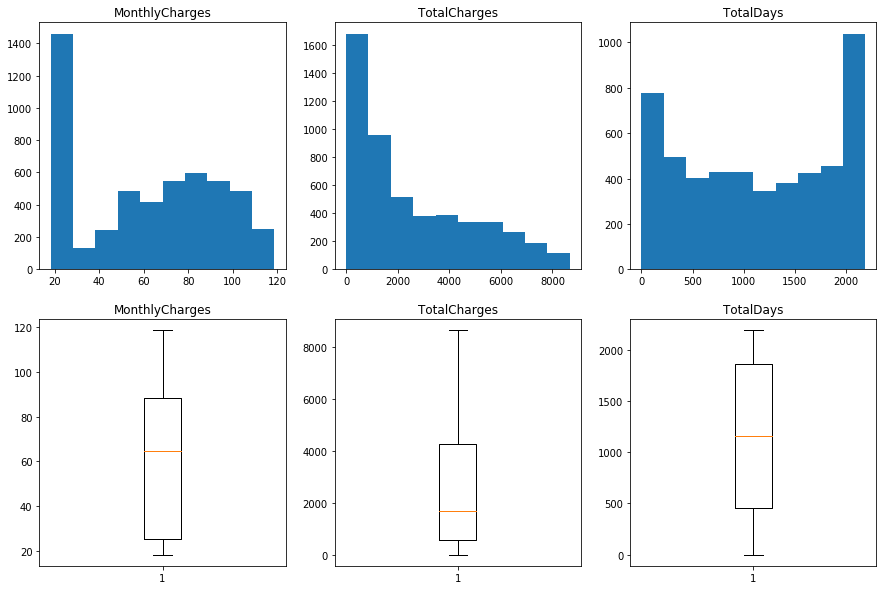

,MonthlyCharges,TotalCharges,TotalDays
count,5174.000000,5174.000000,5174.000000
mean,61.265124,2549.911442,1144.447236
std,31.092648,2329.954215,733.897937
min,18.250000,0.000000,0.000000
25%,25.100000,572.900000,457.000000
50%,64.425000,1679.525000,1157.000000
75%,88.400000,4262.850000,1857.000000
max,118.750000,8672.450000,2191.000000


In [32]:
plot_numerical(churn_df[churn_df['Churn'] == 0])

**Выводы**:
* Со временем вероятность отказа от услуг снижается 
* Обычно отказывались от услуг те, кто платил больше
* Текущие клиенты платят немного меньше в месяц, чем те, кто отказался 

Рассмотррим матрицу корреляции 

In [33]:
churn_df.corr()['Churn'].sort_values(ascending=False)

Churn             1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
TotalCharges     -0.198324
TotalDays        -0.352673
Name: Churn, dtype: float64

Наши предположения подтвердились: 
* чем дольше клиент пользовался услугами, тем меньше вероятность, что он уйдет
* чем выше цена за услуги в месяц, тем больше вероятность, что клиент уйдет

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Отдичный анализ. Напомню только пару моментов:<br>
1) графический анализ - это предположение/гипотеза. И чтобы её подтвердить или опровергнуть также следует применять аналитические методы анализа из области "проверка гипотез".<br>
2) Техника корреляций - ТОЛЬКО для количественных данных. бинарные и номинальные - лучше не смотреть.

<div class="alert alert-success">
Выведем корреляцию между всеми количественными данными
</div>

In [34]:
churn_df[numeric_columns].corr()

,MonthlyCharges,TotalCharges,TotalDays
MonthlyCharges,1.000000,0.651174,0.247754
TotalCharges,0.651174,1.000000,0.826109
TotalDays,0.247754,0.826109,1.000000


Можно заметить, что у нас присутствует проблема мультиколлинеарности в данных - корреляция между `TotalCharges` и `TotalDays` - 0.82, что логично - чем дольше клиент платит, тем больше итоговая сумма. Удалим поле `TotalCharges` 

In [35]:
del churn_df['TotalCharges']
numeric_columns = ['MonthlyCharges', 'TotalDays']

<a name="prepare_data_for_models"></a>
## Подготовка данных для моделей

Удалим ненужные для обучения столбцы `BeginDate` и `EndDate`

In [36]:
del churn_df['BeginDate'], churn_df['EndDate']

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
ОТЛИЧНО, что удаляешь факторы-даты!!!!! Если у нас тема НЕ временные ряды, то такие факторы лучше не использовать. Они "нагонят" метрики, но бизнес-эффективность модели  - рухнет.

Применим технику OHE (One-Hot Encoding) для того, чтобы преобразовать категоральные признаки в численные 

In [37]:
churn_df = pd.get_dummies(churn_df, drop_first=True)

In [38]:
churn_df.head(5)

,MonthlyCharges,Churn,TotalDays,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
CustomerID,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,0,31,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56.95,0,1036,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53.85,1,61,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42.30,0,1371,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70.70,1,61,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
принято.

Выделим фичи и целевой показатель `Churn` 

In [39]:
target = churn_df['Churn'] 
features = churn_df.drop(columns=['Churn'])

Разделим датафрейм на обучающую и тестовую выбороки

In [40]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

Проведем масштабирование количественных признаков

In [41]:
scaler = StandardScaler()

scaler.fit(features_train[numeric_columns])

features_train = features_train.copy()
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])

features_test = features_test.copy()
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

Проверим баланс классов

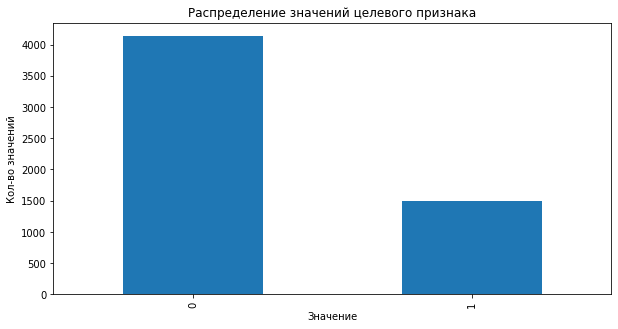

In [42]:
target_train.value_counts().plot(
    kind='bar', 
    figsize=(10, 5), 
    legend=False, 
    title='Распределение значений целевого признака', 
).set(xlabel='Значение', ylabel='Кол-во значений')
plt.show()

In [43]:
ratio = target_train[target_train == 1].count() / target_train[target_train == 0].count()

Видно, что присутсвует дисбаланс классов, надо будет провести upsampling, т.е увеличить число объектов меньшего класса путём их многократного копирования.

In [44]:
features_train, target_train = upsample(features_train, target_train, 3)

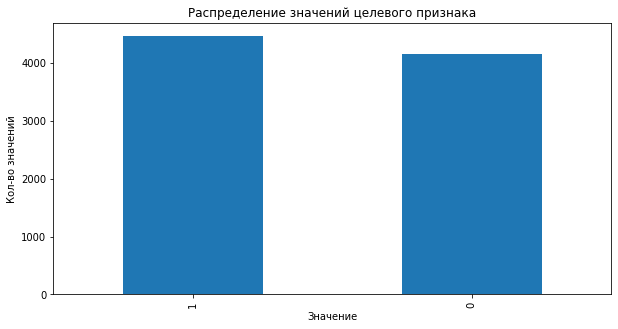

In [45]:
target_train.value_counts().plot(
    kind='bar', 
    figsize=(10, 5), 
    legend=False, 
    title='Распределение значений целевого признака', 
).set(xlabel='Значение', ylabel='Кол-во значений')
plt.show()

Видно, что распределение значений целевого признака выправилось

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
да, понял.

<a name="models_train"></a>
## Обучение моделей

### LogisticRegression

Сначала попробуем обучить модель логистической регрессии

In [46]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

model = LogisticRegression(solver='lbfgs', n_jobs=-1)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'C': 100}


ROC-AUC score 0.8437636088838795


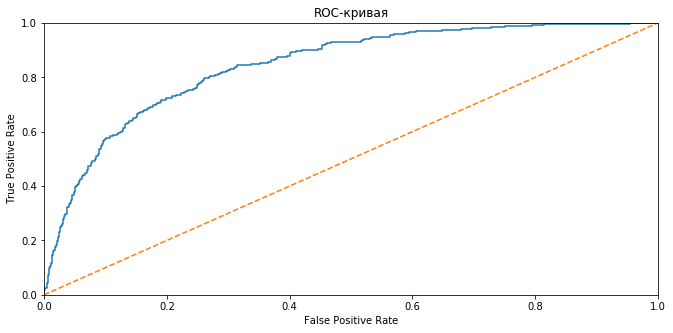

In [47]:
plot_roc_curve(target_test, predicted_probalities)

### RandomForestClassifier

In [48]:
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100], 
}

model = RandomForestClassifier(random_state=RANDOM_STATE)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


ROC-AUC score 0.8500256167225964


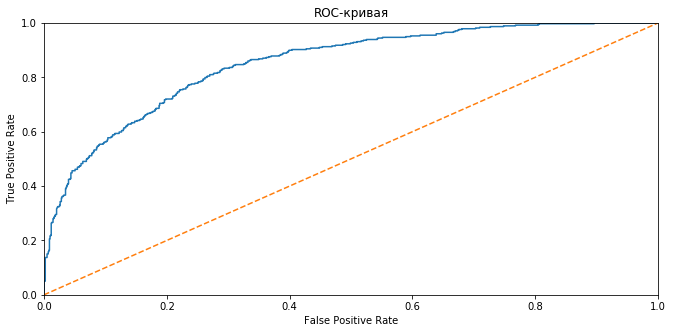

In [49]:
plot_roc_curve(target_test, predicted_probalities)

### CatBoostClassifier

In [50]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [50, 100],
    'l2_leaf_reg': [3, 9]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.3}


ROC-AUC score 0.9142557061249584


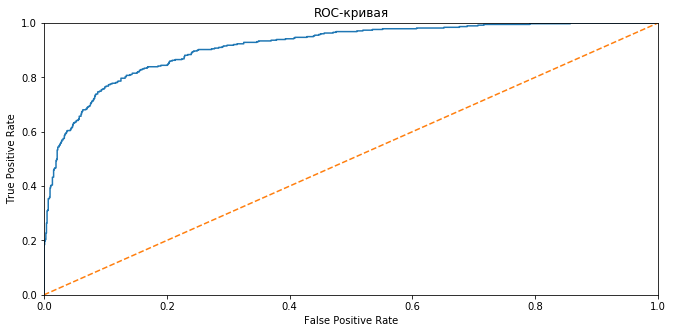

In [51]:
plot_roc_curve(target_test, predicted_probalities)

<div class="alert alert-success">
Catboost показал лучшее значение метрики ROC-AUC - 0.91 
<br>
Вычилим важность факторов
</div>

In [52]:
importances_df = pd.DataFrame(search.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df

,importances
TotalDays,59.023932
MonthlyCharges,11.664119
InternetService_Fiber optic,4.060303
Type_Two year,3.333899
Type_One year,1.953484
PaymentMethod_Electronic check,1.937646
OnlineSecurity_Yes,1.789360
TechSupport_Yes,1.653227
StreamingMovies_Yes,1.563230
Gender_Male,1.514801


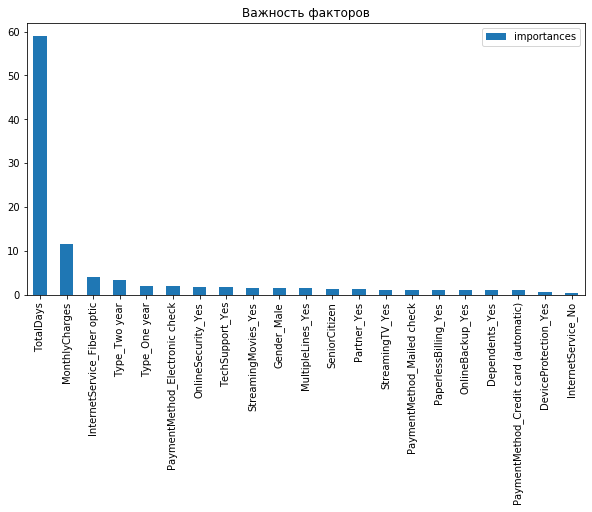

In [53]:
importances_df.plot(kind='bar', figsize=(10, 5), title='Важность факторов')
plt.show()

<a name="conclusion"></a>
## Вывод

* В данной работе проведена работа по предсказанию того, откажется ли клиент от услуг оператора сотовой связи или нет
* Сначала данные были прочитаны и по ним были сделаны предварительные выводы 
* После этого была произведена первичная обработка данных - переименованы столбцы, изменены типы данных 
* Были добавлены 2 новых столбца - целевой признак `Churn`, который означает отказался ли клиент от услуг и `TotalDays`, который обозначает сколько по времени пользователь пользовался услугами
* После этого был проведен исследовательский анализ данных - проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком
* Были сделаны следующие выводы: со временем вероятность отказа от услуг снижается и обычно отказывались от услуг те, кто платил больше
* После этого была проведена подготовка данных к обучению моделей: удалены ненужные столбцы, применена техника OHE, датафрейм был разделен на обучающую и тестовую выборки, проведено масштабирование количественных признаков и проведен upsample
* Затем на данных были обучены 3 модели: LogisticRegression, RandomForestClassifier и CatBoostClassifier
* Лучший результат показала модель CatBoostClassifier со значением метрики ROC-AUC в 0.91, что выше, чем значение, требуемое в задании
* Самые важные факторы - сколько клиент пользуется услугами и сколько он платит в месяц 

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Алексей, уверенная работа, на мой взгляд)<br>
Обработка данных, размышления над факторами, многогранная модельная работа, конечные результаты - многое удалось как надо<br> 
А что совсем хорошо, так это то, что не стал гнаться за точностью любой ценой, даже ценой наружения бизнес-логики. (это я про даты-признаки, многие их вставляют...)<br>

Прежде, чем идти дальше, напомню из прошлых наших общений основные моменты, которые бы мне хотелось зафиксировать, как важные для момделирования (что-то ты и так хорошо используешь):<br>   
1) F1, Акураси и AUC - отличные метрики, но нужно держать в голове, что это лишь бобщённые характеристики. А в реальной практике бизнесу часто важно знать детали самой ошибки - из каких ошибок/успехов она складывается. И в этом случае очень кстати будут меры полноты и точности. Рассмотри возможность их использования для своих проектов. Только через них можно выйти на финансовые возможности модели. Ведь перед запуском её в бой, будет сравнение стоимости создания и поддержки модели со стомостью "оставить как есть" 
    
2) При анализе факторов влияния (их зависиомть между собой и на целевую) происходит по одному из трёх алгоритмов, исходя из типа шкалы. Могут применять следующие графический и аналитический анализы:<br>
- колличественная-колличественная: аналитически методод - корреляции, графический - скатерплот.<br>
- колличественная-номинальная: аналитически методод - проверка гипотез (стьюдент, маннауитни), графический - боксплот.<br>
- номинальная-номинальная: аналитически методод - Хи-квадрат, графический - круговая диаграмма<br>
Это я к тому разделу, который посвящён анализу данных. Там ты сделал интересные предположения и чтобы их доказать, стои проверить аналитически. Вот как раз те методы проверки гипотез, что выше написал.<br>
    
3) Алгоритм нахождения модели может быть таким:<br>
- изучаем проблематику бизнеса и самой темы (в данном случае отток). Пытаемся понять суть явления.<br>
- генерируем разные факторы влияния - любые.<br>
- дизайнируем (прикидываем модели) какие методы решения есть, чтобы решить проблему.<br>
- Смотрим, какие данные и в какой шкале есть. Что нужно ещё, что применить выбранный метод.<br>
- строим модели и анализируем те фактры, какие сгенерировали ранее.<br>
- Думаем над тем, какие причины (факторы) могут ещё влиять на отток.<br>
- если после нескольких итераций точность "замирает" - значит достигли потолка)<br>
 
4) Проведение анализа важности факторов с помощью команды feature_importances_ (+графический анализ). Отличная вещь намечается: высока я метрика + график рейтинаг факторов по силе влияния на целевой признак). Важнейшая часть любого модельного финала. Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют на уход клиента.

<font color='red'>
Есть пару-тройку вопросов для дополнений:<br>
1)При моделировании существует проблематика мультиколлинеарности.(когда количественные факторы имеют сильную корреляцию друг с другом - больше 0.8).Есть ли она у нас?  Если есть - надо  решать по понятиям:) (удалить лишнее)<br><br>
2) Будет здорово, если построишь график важности факторов.
<font color='green'>
Однозначно видно, что ты технически сделал хорошую работу.<br>
Просто эти два пункта - важный момент в алгоритме моделирования. И хотелось, чтобы они у тебя остались в финале.<br>

Спасибо)<br>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ.

<div class="alert alert-success">
Добавил вычисление и графическое ототбражение важности факторов. Также сформулировал на основе этих данных выводы
<br>
Удалил поле TotalCharges, потому что оно коррелирует с TotalDays
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
Привет, Алексей! Увидел твои доработки. Хорошо удалось ещё поработать!<br>
В общем-то, всё по делу. Мне добавить больше нечего, миссия закончена..(<br>

Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)